# Machine Learning Engineer Nanodegree
## Capstone Project
Louis Wan  
May 7th, 2018

## I. Definition

### Project Overview

Algorithmic trading begins in the early 1970s introduced by New York Stock exchange. Many traders and engineers develop technical indicators to identify the market status. After 10 years, algorithmic trading became widely used in trading S&P 500 equity and futures markets. As the development of electronic communication networks goes on and the US decreased the minimum tick size, Algo-trading was strongly encouraged. Till 2001, the concept of machine learning based trading agent is built by a team of IBM. [#1] IBM owns MGD and Hewlett-Packard owns ZIP. Both of the agents out-perform human traders.

The financial market is dynamic and full of uncertainty. Lots of financial industry like hedge funds have to works well with data, like time series data like the price of stocks and futures and multidimensional data like fundamental factors of a company. Investment bank hires many financial experts to building strategies for trading but people work emotionally. Algorithmic trading can help the expert to do judgment but the signals and indicators are all defined by a human. Algo-trading just provides a systematic way to trade according to a human logic. Can we build a reinforcement agent that can recognize signal by itself? This is the propose of this project.

### Problem Statement
Over hundreds of technical and statistical indicators are used for machine learning based trading agent. After training, the agent can turn the indicators into trading decisions(buy or sell with different amount). The agent at first will take data and theirs TAs as input. Then calculate the 'score' of each fund. It is considered as a classification problem. In the second part, we may directly correct the score to the nearest integer percentage(MPF must have an integer percentage i.e. the smallest unit is 1%) and assign it to the portfolio weight.

### Metrics
We will use the CAR/MDD for assessing trend-trading algorithm. The higher the CAR/MDD mean the higher ratio of compound annual return(reward) to maximum drawdown(risk). The definition is stated below.


In [24]:
import numpy as np
import pandas as pd
from datetime import datetime


def car(_date, X):
    start = datetime.strptime(_date[0], '%d/%m/%Y')
    end = datetime.strptime(_date[-1], '%d/%m/%Y')
    delta = end - start
    delta_days = delta.days
    delta_years = float(delta_days) / 365
    print(delta_years)
    return_rate = (X[-1] - X[0])/X[0]
    return np.power(1 + return_rate, 1.0/delta_years) - 1


def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (x - peak) / peak
        if dd < mdd:
            mdd = dd
    return mdd 

In [25]:
file_name = 'dataset/HK_Equity_Fund_B_testing.csv'
df = pd.read_csv(file_name)
date_list = df.Date.values.tolist()
price_list = df.Price.values.tolist()
_car = car(date_list, price_list) * 100
_mdd = max_drawdown(price_list) * 100
print('Compound Annuel Return = %.4f percent' % _car)
print('Maximum DrawDown = %.4f percent' % _mdd)
print('CAR/MDD = %.4f' % (_car/_mdd))

3.4054794520547946
Compound Annuel Return = 9.4378 percent
Maximum DrawDown = -28.0587 percent
CAR/MDD = -0.3364


You will obtain the performance of holding Sun Life MPF Hong Kong Equity Fund (Class B) by running the block above. The fund with the best performance is Sun Life MPF Hong Kong Equity Fund (Class B) in the testing period. The compound annual return is 9.4378 percent and the maximum drawdown of the fund is 28.0587 percent. So, the CAR/MDD is 0.3364. If the learning agent has both high CAR/MDD and the CAR, that's means the learning agent is better than the benchmark. The CAR/MDD is wrapped as a class named CarMddRatio in file evaluation_metric.py

In [26]:
from evaluation_metric import CarMddRatio

file_name = 'dataset/HK_Equity_Fund_B_testing.csv'
df = pd.read_csv(file_name)
metric = CarMddRatio(df)
print('CAR/MDD = %.4f' % metric.get_car_mdd_ratio())

CAR/MDD = 0.3364


## II. Analysis

### Data Exploration
The project will use Sun Life Rainbow mandatory provident fund(MPF) Scheme for financial trading products. The reason why using Sun Life MPF is that of these funds include a different kind of global instrument such as bonds, stocks, and foreign exchanges. Less noise has to tackle with. Secondly, Sun Life MPF service charge is counted and reflected inside the product itself with little entry barrier. Usually, the bond trading is requiring 1.5M cash in security account which is not feasible for the majority of people. The twelve funds are provided by Sun Life MPF.

### Exploratory Visualization
The project will use Sun Life Rainbow mandatory provident fund(MPF) Scheme for financial trading products. [#2] The reason why using Sun Life MPF is that of these funds include a different kind of global instrument such as bonds, stocks, and foreign exchanges. Less noise has to tackle with. Secondly, Sun Life MPF service charge is counted and reflected inside the product itself with little entry barrier. Usually, the bond trading is requiring 1.5M cash in security account which is not feasible for the majority of people. The twelve funds are provided by Sun Life MPF.

Sun Life Rainbow MPF Scheme 

#### Included for trading
1. Sun Life MPF Conservative Fund (Class B), Launch Date: 01 Dec 2000
2. Sun Life MPF Hong Kong Dollar Bond Fund (Class B), Launch Date: 01 Dec 2000
3. Sun Life MPF Stable Fund (Class B), Launch Date: 01 Dec 2000
4. Sun Life MPF Balanced Fund (Class B), Launch Date: 01 Dec 2000
5. Sun Life MPF Growth Fund (Class B), Launch Date: 01 Dec 2000
6. Sun Life MPF Hong Kong Equity Fund (Class B), Launch Date: 01 Dec 2000

#### Excluded from trading
7. Sun Life MPF Global Equity Fund (Class B), Launch Date: 01 Mar 2008
8. Sun Life MPF Asian Equity Fund (Class B), Launch Date: 01 Mar 2008
9. Sun Life MPF Greater China Equity Fund (Class B), Launch Date: 01 Mar 2008
10. Sun Life MPF Global Bond Fund (Class B), Launch Date: 01 Jan 2010
11. Sun Life MPF RMB and HKD Fund (Class B), Launch Date: 30 Jun 2012
12. Sun Life FTSE MPF Hong Kong Index Fund (Class B), Launch Date: 10 Dec 2013

Fund number 1 to 6 will be used for trading only due to the length of data of fund No. 7 to 12 is not enough. For technical indicators, I will use the python package named TA-lib for generating indicators. Since the only close price of the fund can be used, some of the indicators will not be available for use. I will use data from 01 Dec 2000 to 31 Dec 2017, total 6240 days. The data will be split into training and testing data in proportion 80/20. 

The training data is 4992 days(from 01 Dec 2000 to 02 Aug 2014) and the testing data is 1428 days(from 02 Aug 2014 to 31 Dec 2017). The financial data available in the world (index of the major market, fx rate, interest rate) will also include in the dataset. The data will grab from Yahoo! Finance. [#3]

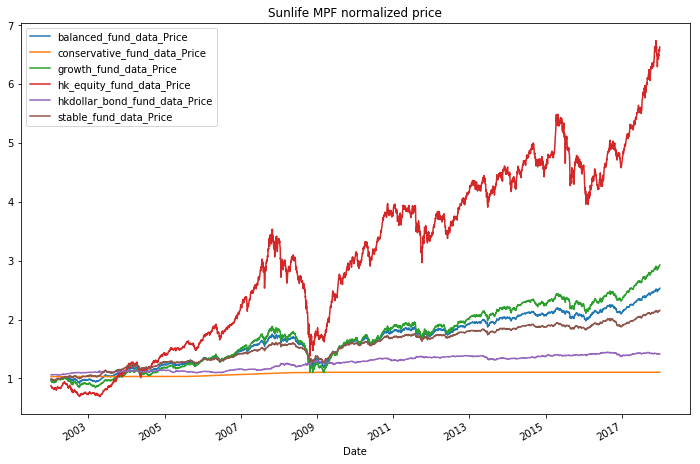

In [27]:
from data_preprocess import DataMerger
import matplotlib.pyplot as plt

fund_fname_list = [
    'dataset/balanced_fund_data.csv',
    'dataset/conservative_fund_data.csv',
    'dataset/growth_fund_data.csv',
    'dataset/hk_equity_fund_data.csv',
    'dataset/hkdollar_bond_fund_data.csv',
    'dataset/stable_fund_data.csv',
    'dataset/HSI_investing_com.csv',
    'dataset/IXIC_investing_com.csv',
    'dataset/us2yrbondyield_investing_com.csv',
    'dataset/us10yrbondyield_investing_com.csv'
]

plot_config = {
    'fund': {
        'config': {
            'title': 'Sunlife MPF normalized price',
            'figsize': (12, 8)
        },
        'colnames':[
            'balanced_fund_data_Price',
            'conservative_fund_data_Price',
            'growth_fund_data_Price',
            'hk_equity_fund_data_Price',
            'hkdollar_bond_fund_data_Price',
            'stable_fund_data_Price',
        ]
    },
    'index': {
        'config': {
            'title': 'All index price data',
            'figsize': (12, 8)
        },
        'colnames':[
            'HSI_investing_com_Price',
            'IXIC_investing_com_Price'
        ]
    },
    'bond': {
        'config': {
            'title': 'All bond yield data',
            'figsize': (12, 8)
        },
        'colnames':[
            'us2yrbondyield_investing_com_Price',
            'us10yrbondyield_investing_com_Price'
        ]
    }
}

data_merger = DataMerger(fund_fname_list)
merged_df = data_merger.run(save_csv=False)
merged_df[plot_config['fund']['colnames']].plot(**plot_config['fund']['config'])

Data of Heng Send index, NASDAQ Composite Index, US 2-year and 10-year bond yield will also be used for analysis.

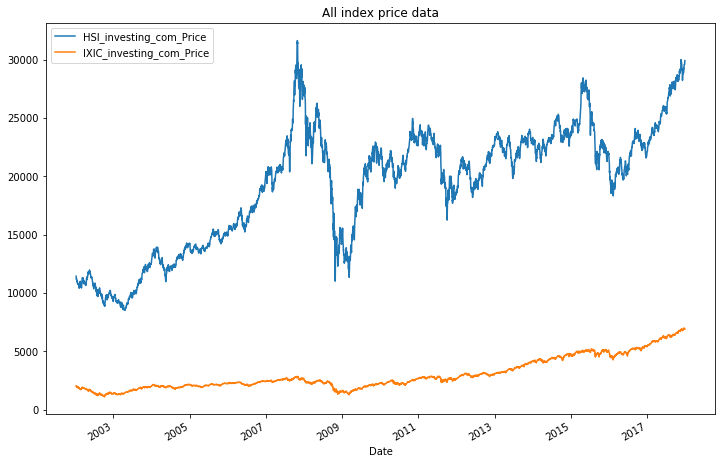

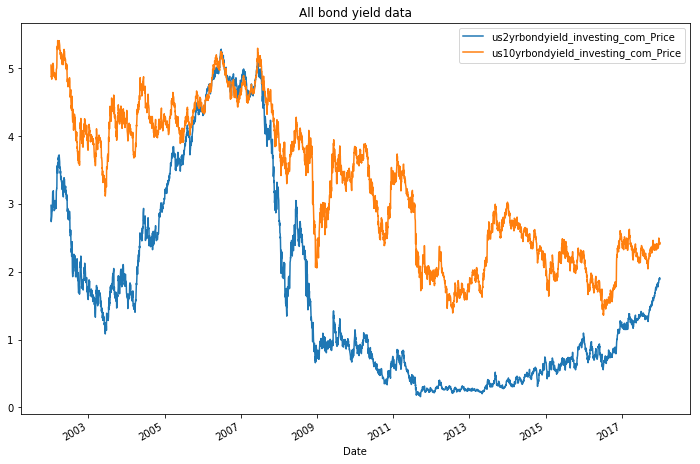

In [28]:
merged_df[plot_config['index']['colnames']].plot(**plot_config['index']['config'])
merged_df[plot_config['bond']['colnames']].plot(**plot_config['bond']['config'])

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

Logistic Regression, Decision tree regreessor and Multiple layer perceptron are common machine learning algorithms for classification problem. Logistic regression(Logit model) is the most basic linear model for classification. This model is receiving a set of variables and sum up. Finally get a value after input to the sigmoid function. Since the logit model is based on ordinary least square(OLS) estimation, the input variable is requiring normally distributed, mutually independent and homoscedasticity. Stock prices and its technical indicators may violate the assumptions. The variable selection have to be handle carefully.

Another method to be suggested is decision tree classifier (classification trees). It takes a discrete set of values into tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. It finally calculates the scores of each class. Multiple layer perceptron have similar structure but function differently. It does linear transform in each node at the beginning. And then, It transform the value by activation function and finally get the likelihood of each class.

Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?

Three of the models stated above will be tested. For the variable used, all the daily close price of each fund, the MACD, RSI and other technical indicators of each fund will also be used.

### Benchmark
The fund with the best performance is Sun Life MPF Hong Kong Equity Fund (Class B) in the testing period The compound annual return is 9.4378 percent and the maximum drawdown of the fund is 28.0587 percent. So, the CAR/MDD is 0.3364. If the learning agent has both high CAR/MDD and the CAR, that's means the learning agent is better than the benchmark.

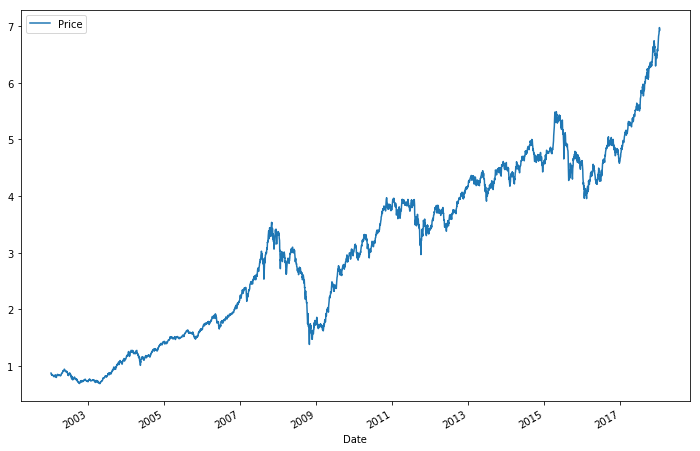

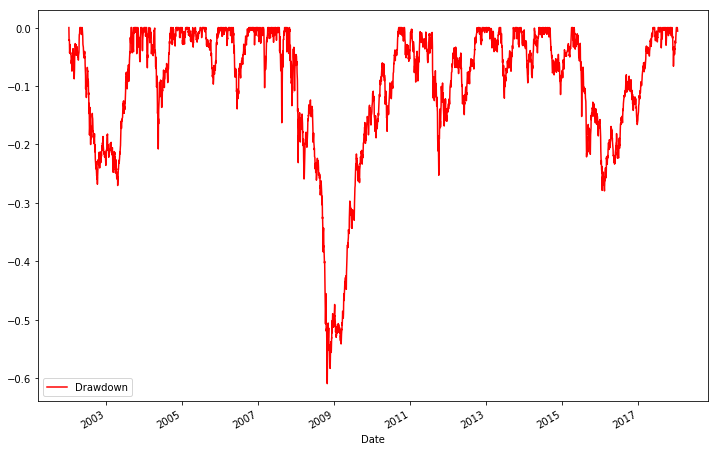

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


def drawdown_curve(_price):
    dd = list()
    peak = _price[0]
    for x in _price:
        if x > peak:
            peak = x
        dd.append((x - peak) / peak)
    return dd


hk_eq_fname = 'dataset/hk_equity_fund_data.csv'
hk_equity_fund_df = pd.read_csv(hk_eq_fname)
hk_equity_fund_df['Date'] = pd.to_datetime(hk_equity_fund_df['Date'], format='%Y-%m-%d')
hk_equity_fund_df = hk_equity_fund_df.sort_values('Date')
hk_equity_fund_df.index = range(len((hk_equity_fund_df)))
drawdown = drawdown_curve(hk_equity_fund_df['Price'])
hk_equity_fund_df['Drawdown'] = drawdown
hk_equity_fund_df = hk_equity_fund_df.set_index('Date')
hk_equity_fund_df[['Price']].plot(figsize=(12, 8))
hk_equity_fund_df[['Drawdown']].plot(figsize=(12, 8), style='r-')

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:

- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_



### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?